In [2]:
%matplotlib inline
import numpy as np
from sklearn import svm
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
with open("/home/christopher/data/ml/digit-recognizer/train.csv", "r") as data:
    fullTrain = np.loadtxt(data, delimiter=",", skiprows=1, dtype="float64")
with open("/home/christopher/data/ml/digit-recognizer/test.csv", "r") as data:
    fullTest = np.loadtxt(data, delimiter=",", skiprows=1, dtype="float64")

In [4]:
train = fullTrain
test = fullTest

In [5]:
trainResults = train[:,0]
trainData = train[:,1:]
testData = test

# Look at the data

Let's look at the data and think about it so that we can do more intelligent things than just throw statistics at it.

In this case I am not sure that we can, but this is a good step later where there may be some theory or physics that we can apply.

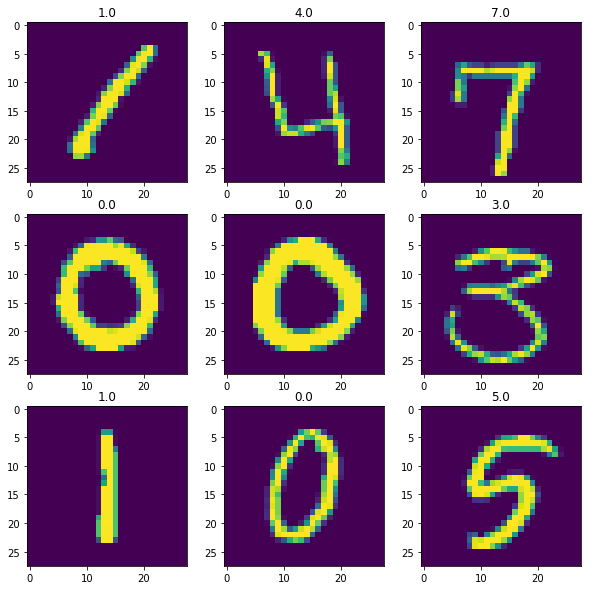

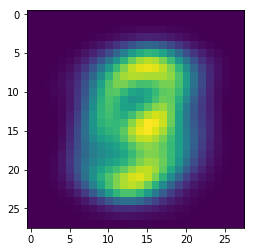

In [43]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(9):
    ax = axs[i%3][i//3]
    ax.imshow(trainData[i].reshape(28, 28))
    ax.set_title(trainResults[i])

fig, ax = plt.subplots()
ax.imshow(np.mean(trainData, axis=0).reshape(28, 28))

# Scaling

We need to scale our data to have mean 0, variance 1. 

In [6]:
scaler = preprocessing.StandardScaler().fit(trainData)
scaledTrainData = scaler.transform(trainData)
scaledTestData = scaler.transform(testData)

# PCA

Not all of the components of our vectors have useful data. We can run PCA to determine which + how many components we need.

First, let us just play with the data and see how many components are needed to get certain percentages of data explained.

Then we can apply a cut.

In [7]:
from sklearn.decomposition import PCA
pcaTest = PCA()
pcaTest.fit(scaledTrainData)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0.8, 1.0)

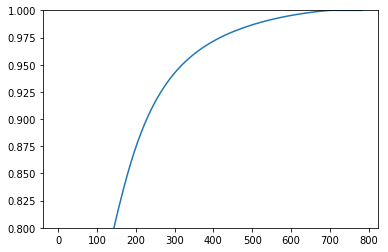

In [8]:
cumulative_explained = [0]
for i in range(len(pcaTest.explained_variance_ratio_)):
    cumulative_explained.append(sum(pcaTest.explained_variance_ratio_[:i+1]))
plt.plot(cumulative_explained)
plt.ylim([0.8, 1.0]) # we only care about the high end

For this component remember:
Large positive values mean that there is lots of variance in that feature.
Values close to 0 mean that there is little variance along in that feature.
Large negative values mean that (I think the same as large positive but I'm not sure).



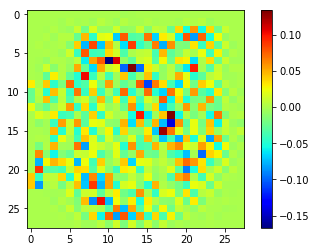

In [24]:
# Let's look at some components
plt.imshow(pcaTest.components_[600].reshape(28,28), cmap='jet')
plt.colorbar()
assert sum(pcaTest.components_[0]**2) - 1 < 0.00001
print("""For this component remember:
Large positive values mean that there is lots of variance in that feature.
Values close to 0 mean that there is little variance along in that feature.
Large negative values mean that (I think the same as large positive but I'm not sure).
""")

In [74]:
import plotly.offline as py
import plotly.graph_objs as go

data = [
    go.Heatmap(z = np.sum(np.power(pcaTest.components_[:i], 2), axis=0).reshape(28, 28))
]
py.iplot(data, filename='basic-heatmap')

"""
fig, ax = plt.subplots()
img = ax.imshow(np.zeros((28, 28)))
fig.colorbar(img)
plt.show()
for i in range(1,784):
    summedComponents = np.sum(np.power(pcaTest.components_[:i], 2), axis=0)
    img.set_data(summedComponents.reshape(28, 28))
    plt.draw()
    print(i)
"""

'\nfig, ax = plt.subplots()\nimg = ax.imshow(np.zeros((28, 28)))\nfig.colorbar(img)\nplt.show()\nfor i in range(1,784):\n    summedComponents = np.sum(np.power(pcaTest.components_[:i], 2), axis=0)\n    img.set_data(summedComponents.reshape(28, 28))\n    plt.draw()\n    print(i)\n'

Having played with it to get a sense of what is going on, lets actually use PCA to reduce the size of our data

In [25]:
pca = PCA(n_components=0.99) # Get 99% of the info
pca.fit(scaledTrainData)
redScaledTrainData = pca.transform(scaledTrainData)
redScaledTestData = pca.transform(scaledTestData)

# Fit

Fit a support vector classification model to our data then predict our test data from that.

In [26]:
clf = svm.SVC()   
_ = clf.fit(redScaledTrainData, trainResults)

In [ ]:
# Now lets analyse what our clf has found
print(clf.score(redScaledTrainData, trainResults))

In [ ]:
res = clf.predict(redScaledTestData)

In [ ]:
with open("results.csv", "w") as f:
    f.write("ImageId,Label\n")
    for i, r in enumerate(res):
        f.write("{},{}\n".format(i+1, int(r)))